# Imports

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Embedding, Dropout, Input, Flatten, BatchNormalization, concatenate, AlphaDropout

from google.colab import drive
import joblib

# Conectar a datos

In [ ]:
read_dir = '/content/drive/MyDrive/Universidad/TFG/data_ready/'
save_dir = '/content/drive/MyDrive/Universidad/II-TI_4º/IE/'

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Leer datos y preparar para ML

In [ ]:
df = pd.read_csv(read_dir+'LEARNING_DF_NORMAL.csv')
df = df.loc[df['year'] >= 2000].copy()
df = df.drop(['age',	'experience', 'driversPointsBeforeRace', 'constPointsBeforeRace'], axis=1)

# Clipping maximuns on grid and position
df['grid'] = df['grid'].clip(upper=20)
df['position'] = df['position'].clip(upper=20)

# Fit continous columns
scaler_mm = MinMaxScaler(feature_range=(1,20))
columns_to_scale = ['year']
df[columns_to_scale] = scaler_mm.fit_transform(df[columns_to_scale])

# Fit boolean columns
columns_to_replace = ['weather_warm', 'weather_cold', 'weather_dry', 'weather_wet', 'weather_cloudy']
df[columns_to_replace] = df[columns_to_replace].replace(1,20)


y = df['position']
drivers = df['driverId']
constructors = df['constructorId']
circuits = df['circuitId']
X = df.drop(['driverId', 'constructorId', 'circuitId', 'position'], axis=1)


# Max index 
N_DRIVERS = 858 + 1
N_CONSTRUCTORS = 214 + 1
N_CIRCUITS = 80 + 1
N_NUMERICS = X.shape[1]

In [ ]:
X

,grid,year,round,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy
0,1,7.608696,1,0,0,0,0,0
1,9,7.608696,2,0,0,0,0,20
2,3,7.608696,3,0,0,20,0,0
3,5,7.608696,4,20,0,0,0,0
4,3,7.608696,5,20,0,0,0,0
...,...,...,...,...,...,...,...,...
25935,18,20.000000,1,20,0,0,0,0
25936,8,20.000000,2,20,0,0,0,0
25937,16,20.000000,3,20,0,0,0,0
25938,10,20.000000,4,0,0,0,0,20


# Crear modelo

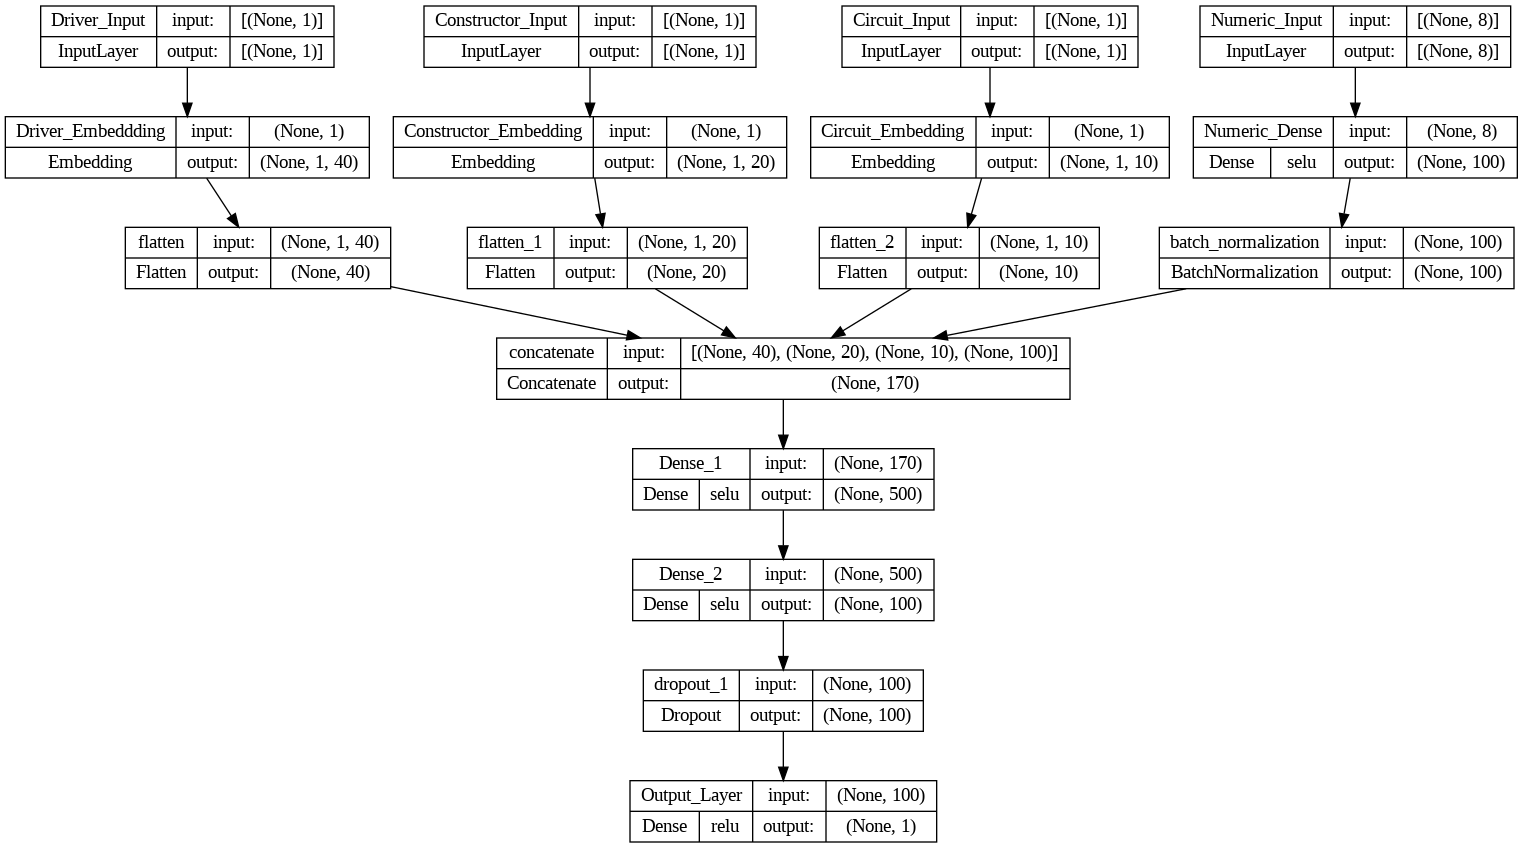

In [ ]:
activation_function = 'selu'
weight_initializer = 'lecun_uniform'





driver_input = Input(shape=(1,), name='Driver_Input')

driver_embedding = Embedding(N_DRIVERS, 
                             40, 
                             input_length=1, 
                             embeddings_initializer=weight_initializer,
                             name='Driver_Embeddding')(driver_input)

driver_flatten = Flatten()(driver_embedding)







constructor_input = Input(shape=(1,), name='Constructor_Input')

constructor_embedding = Embedding(N_CONSTRUCTORS, 
                                  20, 
                                  input_length=1, 
                                  embeddings_initializer=weight_initializer,
                                  name='Constructor_Embedding')(constructor_input)

constructor_flatten = Flatten()(constructor_embedding)







circuit_input = Input(shape=(1,), name='Circuit_Input')

circuit_embedding = Embedding(N_CIRCUITS, 
                              10, 
                              input_length=1, 
                              embeddings_initializer=weight_initializer,
                              name='Circuit_Embedding')(circuit_input)

circuit_flatten = Flatten()(circuit_embedding)









numeric_inputs = Input(shape=(N_NUMERICS,), 
                       name='Numeric_Input')

numeric_dropout = Dropout(rate=0.1)(numeric_inputs)

numeric_dense = Dense(100, 
                      activation=activation_function, 
                      kernel_initializer=weight_initializer, 
                      name='Numeric_Dense')(numeric_inputs)

numeric_normalization = BatchNormalization()(numeric_dense)





concat_inputs = concatenate([driver_flatten, constructor_flatten, circuit_flatten, numeric_normalization])








dense_1 = Dense(500, 
                activation=activation_function, 
                kernel_initializer=weight_initializer, 
                name='Dense_1')(concat_inputs)

dense_2 = Dense(100, 
                activation=activation_function, 
                kernel_initializer=weight_initializer, 
                name='Dense_2')(dense_1)

dropout_1 = Dropout(rate=0.3)(dense_2)

out_layer = Dense(1, 
                  activation='relu', 
                  kernel_initializer='he_uniform',
                  name='Output_Layer')(dropout_1)



model = keras.models.Model(inputs=[driver_input, constructor_input, circuit_input, numeric_inputs],
                           outputs=out_layer)


keras.utils.plot_model(model,
                       show_shapes=True,
                       show_layer_activations=True)

# Entrenar Modelo

In [ ]:
optim = keras.optimizers.Nadam(learning_rate=0.001)

model.compile(optimizer=optim,
              loss='mae',
              metrics=['accuracy', 'MeanAbsoluteError'])

callback = keras.callbacks.EarlyStopping(monitor='loss',
                                         patience=200)

In [ ]:
history = model.fit([drivers, constructors, circuits, X],
                    y,
                    batch_size=64,
                    epochs=3000,
                    shuffle = True,
                    callbacks=[callback])

Se han truncado las últimas 5000 líneas del flujo de salida.
145/145 [==============================] - 1s 9ms/step - loss: 0.9083 - accuracy: 0.0248 - mean_absolute_error: 0.9083
Epoch 98/3000
145/145 [==============================] - 1s 9ms/step - loss: 0.9184 - accuracy: 0.0252 - mean_absolute_error: 0.9184
Epoch 99/3000
145/145 [==============================] - 1s 9ms/step - loss: 0.9138 - accuracy: 0.0220 - mean_absolute_error: 0.9138
Epoch 100/3000
145/145 [==============================] - 1s 10ms/step - loss: 0.9286 - accuracy: 0.0238 - mean_absolute_error: 0.9286
Epoch 101/3000
145/145 [==============================] - 2s 14ms/step - loss: 0.9049 - accuracy: 0.0245 - mean_absolute_error: 0.9049
Epoch 102/3000
145/145 [==============================] - 2s 14ms/step - loss: 0.9153 - accuracy: 0.0232 - mean_absolute_error: 0.9153
Epoch 103/3000
145/145 [==============================] - 2s 11ms/step - loss: 0.9171 - accuracy: 0.0222 - mean_absolute_error: 0.9171
Epoch 104/3000

# Guardar modelo junto con scalers de preprocesado

In [ ]:
model.save(save_dir+'IE_F1_model.h5')
joblib.dump(scaler_mm, save_dir+'IE_F1_minmaxscaler.mod')

['/content/drive/MyDrive/Universidad/II-TI_4º/IE/IE_F1_minmaxscaler.mod']